In [1]:
!pip install -U tensorflow_hub

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.5.0)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf

tf.enable_eager_execution()

In [3]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [4]:
#@param {type:"string"}
#classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/2"

In [5]:
IMAGE_SHAPE=(224,224)
classifier = tf.keras.Sequential([
    #hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
    hub.KerasLayer("/tf/notebooks/tf_official/images/mobilenet_v2_2", 
                     input_shape=IMAGE_SHAPE+(3,))
])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [6]:
classifier

In [7]:
!pip install pillow

/usr/local/lib/python3.6/dist-packages/PIL/Image.py


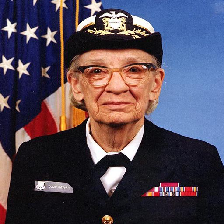

In [8]:
import numpy as np
from PIL import Image
import PIL
print(Image.__file__)
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper


In [9]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [10]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [11]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
print(labels_path)
imagenet_labels = np.array(
                        open(labels_path).read().splitlines())

/root/.keras/datasets/ImageNetLabels.txt


In [13]:
imagenet_labels
imagenet_labels[predicted_class]

'military uniform'

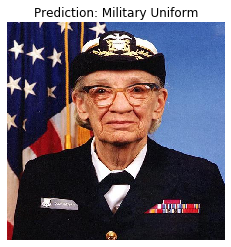

In [14]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)
data_root

In [15]:
data_root= '/tf/notebooks/tf_official/load_data/flower_photos'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

image_data.image_data_generator

Found 3670 images belonging to 5 classes.


In [16]:
!pip install SciPy

In [25]:

import PIL
PIL.__file__
IMAGE_SHAPE

(224, 224)

In [18]:
import scipy
print(scipy.__file__)
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break



/usr/local/lib/python3.6/dist-packages/scipy/__init__.py
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [19]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [20]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['hair slide', 'alp', 'greenhouse', 'hair slide', 'daisy',
       'spider web', 'rapeseed', 'guillotine', 'bee', 'brain coral',
       'bee', 'daisy', 'greenhouse', 'cardoon', 'daisy',
       "yellow lady's slipper", 'daisy', 'daisy', 'maze', 'buckeye',
       'coral reef', 'earthstar', 'daisy', 'cardoon', 'picket fence',
       'swab', 'picket fence', 'hip', "yellow lady's slipper", 'ladybug',
       'daisy', 'daisy'], dtype='<U30')

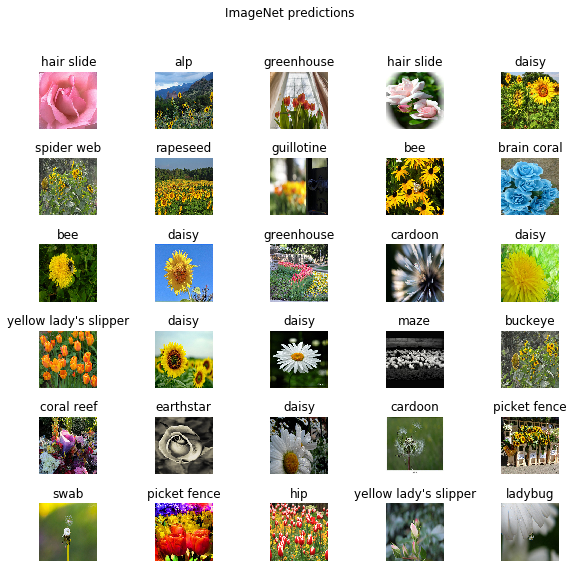

In [21]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [22]:
feature_extractor_path = "/tf/notebooks/tf_official/images/mobilenet_v2_feature_vector_2"

In [23]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_path,
                                        input_shape=(224,224,3))

In [24]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [26]:
feature_extractor_layer.trainable = False

In [27]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
predictions = model(image_batch)
predictions.shape

TensorShape([Dimension(32), Dimension(5)])

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])


In [31]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    def on_train_batch_end(self,batch,logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [50]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
print(steps_per_epoch)

batch_stats_callback =  CollectBatchStats()
batch_stats_callback

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

115.0
Epoch 1/2


W0806 06:39:09.873898 140260507715392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 38s 334ms/step - loss: 0.6130 - acc: 0.9688
Epoch 2/2
115/115 [==============================] - 35s 306ms/step - loss: 0.3249 - acc: 0.9375


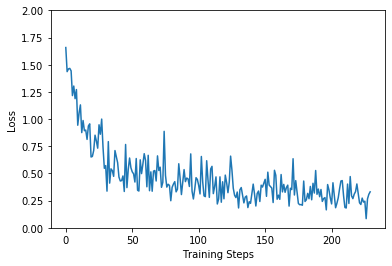

In [55]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

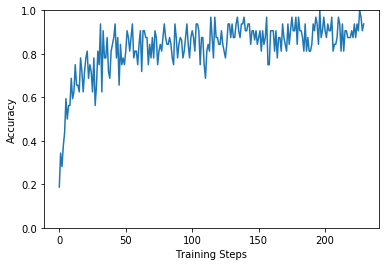

In [56]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [69]:
class_names = sorted(image_data.class_indices.items(),
                    key=lambda pair:pair[1])
print(class_names)
class_names = np.array([key.title() for key,value in class_names])
class_names

[('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)]


array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [75]:
predicted_batch = model.predict(image_batch)
print(predicted_batch.shape)
predicted_batch 
predicted_id = np.argmax(predicted_batch, axis = -1) 
predicted_label_batch = class_names[predicted_id]
predicted_label_batch

(32, 5)


array(['Roses', 'Sunflowers', 'Tulips', 'Roses', 'Sunflowers',
       'Sunflowers', 'Sunflowers', 'Sunflowers', 'Sunflowers', 'Roses',
       'Dandelion', 'Sunflowers', 'Tulips', 'Dandelion', 'Dandelion',
       'Tulips', 'Sunflowers', 'Daisy', 'Tulips', 'Sunflowers', 'Roses',
       'Roses', 'Daisy', 'Dandelion', 'Sunflowers', 'Dandelion', 'Tulips',
       'Tulips', 'Tulips', 'Dandelion', 'Daisy', 'Dandelion'],
      dtype='<U10')

In [85]:

label_id = np.argmax(label_batch, axis=-1)
label_batch
label_id

array([2, 3, 4, 2, 3, 3, 3, 4, 3, 2, 1, 3, 4, 1, 1, 4, 3, 0, 4, 3, 2, 2,
       0, 1, 3, 1, 4, 4, 2, 0, 0, 1])

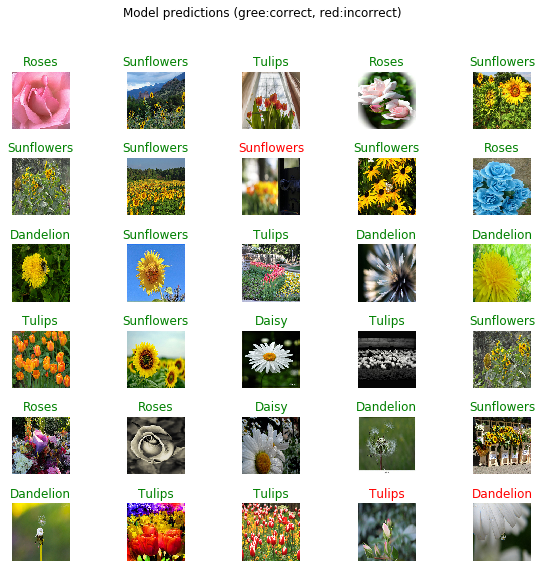

In [87]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5, n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color = color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (gree:correct, red:incorrect)")

In [91]:
import time
t = time.time()
t
export_path="./saved_models_hub_with_keras_1/{}".format(int(t))
export_path
tf.keras.experimental.export_saved_model(model, export_path)
export_path

Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7f8ed6587f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: <tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7f8ed4522048>
W0806 07:29:34.912154 140260507715392 export_utils.py:182] Export includes no default signature!
W0806 07:29:35.758973 140260507715392 meta_graph.py:449] Issue encountered whe

'./saved_models_hub_with_keras_1/1565076567'

In [92]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path,
                     custom_objects={'KerasLayer':hub.KerasLayer})

Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7f8e9ca9bf98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7f8e845aaa90>,)
Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7f8e87259f6

In [93]:
result_batch=model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [94]:
result_batch

array([[3.88809107e-03, 1.79422938e-03, 9.54320967e-01, 1.26311452e-05,
        3.99841927e-02],
       [6.31300872e-03, 6.23909384e-03, 2.88497028e-03, 9.80202138e-01,
        4.36078059e-03],
       [8.69863507e-05, 3.15426246e-06, 1.71214286e-02, 2.89968331e-04,
        9.82498407e-01],
       [1.23737950e-03, 1.82101321e-05, 8.22103798e-01, 4.19013622e-06,
        1.76636383e-01],
       [8.65923706e-03, 5.21861836e-02, 6.15012553e-03, 9.22240078e-01,
        1.07643595e-02],
       [3.45660141e-03, 9.17008594e-02, 1.74302573e-03, 9.02678072e-01,
        4.21485922e-04],
       [5.42751513e-04, 9.55060497e-03, 1.64085836e-03, 9.58201647e-01,
        3.00640278e-02],
       [9.90667343e-02, 4.40217182e-02, 4.17311676e-02, 4.54110205e-01,
        3.61070156e-01],
       [3.59150697e-03, 5.67080919e-03, 4.38316463e-04, 9.86592710e-01,
        3.70662520e-03],
       [3.04460438e-04, 3.42167987e-05, 9.98224080e-01, 1.54377740e-05,
        1.42178964e-03],
       [1.14360396e-02, 6.7754

In [95]:
abs(reloaded_result_batch-result_batch).max()

0.0